In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import os
import time

# I evaluate model on cpu because of the memory constraints

if torch.cuda.is_available():
    device = 'cpu'
    #torch.cuda.set_device(0) 
    #device='cuda:0'
    torch.set_default_tensor_type('torch.FloatTensor')
    #device=torch.cuda.current_device()
else:
    device='cpu'
    torch.set_default_tensor_type('torch.FloatTensor')


# Set up NN-class 
# Name Net_timesteps corresponds to using
# different NNs for each timestep but in the current set up
# coefficients of SDE are neural networks
# and time is one of the inputs 

class Net_timestep(nn.Module):
    def __init__(self, dim, nOut, n_layers, vNetWidth, activation = "relu"):
        super(Net_timestep, self).__init__()
        self.dim = dim
        self.nOut = nOut
        
        if activation!="relu" and activation!="tanh":
            raise ValueError("unknown activation function {}".format(activation))
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
        
        self.i_h = self.hiddenLayerT1(dim, vNetWidth)
        self.h_h = nn.ModuleList([self.hiddenLayerT1(vNetWidth, vNetWidth) for l in range(n_layers-1)])
        self.h_o = self.outputLayer(vNetWidth, nOut)
        
    def hiddenLayerT0(self,  nIn, nOut):
        layer = nn.Sequential(#nn.BatchNorm1d(nIn, momentum=0.1),
                              nn.Linear(nIn,nOut,bias=True),
                              #nn.BatchNorm1d(nOut, momentum=0.1),   
                              self.activation)   
        return layer
    
    def hiddenLayerT1(self, nIn, nOut):
        layer = nn.Sequential(nn.Linear(nIn,nOut,bias=True),
                              #nn.BatchNorm1d(nOut, momentum=0.1),  
                              self.activation)   
        return layer
    
    
    def outputLayer(self, nIn, nOut):
        layer = nn.Sequential(nn.Linear(nIn, nOut,bias=True))
        return layer
    
    def forward(self, S):
        h = self.i_h(S)
        for l in range(len(self.h_h)):
            h = self.h_h[l](h)
        output = self.h_o(h)
        return output
    
#Set up neural SDE class    

class Net_SDE(nn.Module):
    
    def __init__(self, dim, timegrid, strikes_call, strikes_put, ITM_call, OTM_call, ITM_put, OTM_put, n_layers, vNetWidth, device):
        
        super(Net_SDE, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.strikes_put = strikes_put
        
        #Input to each coefficient (NN) will be (t,S_t,V_t)
        
        self.diffusion =Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.driftV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV1 = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        
    def forward(self, S0, V0, rate, indices, z,z1, MC_samples): 
        S_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        V_old = torch.repeat_interleave(V0, MC_samples, dim=0)  
        K_call = self.strikes_call
        K_put = self.strikes_put
        zeros = torch.repeat_interleave(torch.zeros(1,1), MC_samples, dim=0)
        average_SS = torch.Tensor()
        average_SS1 = torch.Tensor()
        average_SS_OTM = torch.Tensor()
        average_SS1_ITM = torch.Tensor()
        # use fixed step size
        h = self.timegrid[1]-self.timegrid[0]
        n_steps = len(self.timegrid)-1
        # set maturity counter
        countmat=-1
        
        # Solve for S_t, V_t (Euler)
        
        for i in range(1, len(self.timegrid)):
            dW = (torch.sqrt(h) * z[:,i-1]).reshape(MC_samples,1)
            dW1 = (torch.sqrt(h) * z1[:,i-1]).reshape(MC_samples,1)
            current_time = torch.ones(1, 1)*self.timegrid[i-1]
            input_time  = torch.repeat_interleave(current_time, MC_samples,dim=0)
            inputNN = torch.cat([input_time.reshape(MC_samples,1),S_old, V_old],1)
            S_new =S_old + S_old*rate*h + self.diffusion(inputNN)*dW 
            S_new = torch.cat([S_new,zeros],1)
            S_new=torch.max(S_new,1,keepdim=True)[0]
            S_old = S_new
            V_new = V_old + self.driftV(inputNN)*h +self.diffusionV(inputNN)*dW + self.diffusionV1(inputNN)*dW1
            V_old = V_new
        
            # If particular timestep is a maturity for Vanilla option
            
            if int(i) in indices:
                countmat+=1
                Z_new=torch.Tensor()
                Z_newP_ITM = torch.Tensor()
                Z_newP_OTM = torch.Tensor()
                countstrikecall=-1
                
            # Evaluate put (OTM) and call (OTM) option prices 
                
                for strike in K_call:
                    countstrikecall+=1
                    strike = torch.ones(1,1)*strike
                    strike_put = torch.ones(1,1)*K_put[countstrikecall]
                    K_extended = torch.repeat_interleave(strike, MC_samples, dim=0).float()
                    K_extended_put = torch.repeat_interleave(strike_put, MC_samples, dim=0).float()

                    # Since we use the same number of maturities for vanilla calls and puts: 
                    
                    price = torch.cat([S_old-K_extended,zeros],1) #call OTM
                    price_OTM = torch.cat([K_extended_put-S_old,zeros],1) #put OTM
                    
                    # Discounting assumes we use 2-year time horizon 
                    
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    price_OTM = torch.max(price_OTM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    
                
                    Z_new= torch.cat([Z_new,price],1)  
                    Z_newP_OTM= torch.cat([Z_newP_OTM,price_OTM],1)  
                    
               # MC step:
            
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_OTM = torch.cat([p.mean().view(1,1) for p in Z_newP_OTM.T], 0)
                average_SS = torch.cat([average_SS,avg_S.T],0) #call OTM
                average_SS_OTM = torch.cat([average_SS_OTM,avg_SSP_OTM.T],0) #put OTM       
                countstrikeput=-1
                
          # Evaluate put (ITM) and call (ITM) option prices 
                
                Z_new=torch.Tensor()
                for strike in K_put:
                    countstrikeput+=1
                    strike = torch.ones(1,1)*strike
                    strike_call = torch.ones(1,1)*K_call[countstrikeput]
                    K_extended = torch.repeat_interleave(strike, MC_samples, dim=0).float()
                    K_extended_call = torch.repeat_interleave(strike_call, MC_samples, dim=0).float()
                    price_ITM = torch.cat([K_extended_call-S_old,zeros],1) #put ITM
                    price = torch.cat([S_old-K_extended,zeros],1) #Call ITM
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    price_ITM = torch.max(price_ITM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    
                    
                    Z_new= torch.cat([Z_new,price],1) 
                    Z_newP_ITM= torch.cat([Z_newP_ITM,price_ITM],1)    
                    
            # MC step         
                    
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_ITM = torch.cat([p.mean().view(1,1) for p in Z_newP_ITM.T], 0)
                average_SS1_ITM = torch.cat([average_SS1_ITM,avg_SSP_ITM.T],0)                            
                average_SS1 = torch.cat([average_SS1,avg_S.T],0)      
                    
            # Return model implied vanilla option prices    
                
        return torch.cat([average_SS,average_SS_OTM,average_SS1,average_SS1_ITM  ],0)  
    
# Net_SDE_Paths outputs paths rather than prices (can be used for calculating exotic prices)    
    
class Net_SDE_Paths(nn.Module):
    
    def __init__(self, dim, timegrid, n_layers, vNetWidth, device):
        
        super(Net_SDE_Paths, self).__init__()
        self.dim = dim
        self.timegrid = torch.tensor(timegrid).to(device)
        self.device = device
        self.strikes_call = strikes_call
        self.strikes_put = strikes_put
        self.diffusion =Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.driftV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV1 = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        
    def forward(self, S0, V0, rate, indices, z,z1, MC_samples): 
        S_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        V_old = torch.repeat_interleave(V0, MC_samples, dim=0)  
        K_call = self.strikes_call
        K_put = self.strikes_put
        zeros = torch.repeat_interleave(torch.zeros(1,1), MC_samples, dim=0)
        average_SS = torch.Tensor()
        average_SS1 = torch.Tensor()
        average_SS_OTM = torch.Tensor()
        average_SS1_ITM = torch.Tensor()
        # use fixed step size
        h = self.timegrid[1]-self.timegrid[0]
        n_steps = len(self.timegrid)-1
        # set maturity counter
        countmat=-1
        Price_paths = torch.repeat_interleave(S0, MC_samples, dim=0)
        Vol_paths = torch.repeat_interleave(V0, MC_samples, dim=0)
        
        # Solve for S_t, V_t (Euler)
        
        for i in range(1, len(self.timegrid)):
            dW = (torch.sqrt(h) * z[:,i-1]).reshape(MC_samples,1)
            dW1 = (torch.sqrt(h) * z1[:,i-1]).reshape(MC_samples,1)
            current_time = torch.ones(1, 1)*self.timegrid[i-1]
            input_time  = torch.repeat_interleave(current_time, MC_samples,dim=0)
            inputNN = torch.cat([input_time.reshape(MC_samples,1),S_old, V_old],1)
            S_new =S_old + S_old*rate*h + self.diffusion(inputNN)*dW 
            S_new = torch.cat([S_new,zeros],1)
            S_new=torch.max(S_new,1,keepdim=True)[0]
            S_old = S_new
            V_new = V_old + self.driftV(inputNN)*h +self.diffusionV(inputNN)*dW + self.diffusionV1(inputNN)*dW1
            V_old = V_new    
            Price_paths = torch.cat([Price_paths,S_old],1)
            Vol_paths = torch.cat([Vol_paths,V_old],1)
            

        return torch.cat([Price_paths,Vol_paths],0)
    
# Net_SDE_Paths_hestons outputs paths for underlaying and volatility
# processes in Heston model 

class Net_SDE_Paths_heston(nn.Module):
    
    def __init__(self, dim, timegrid, n_layers, vNetWidth, device):
        
        super(Net_SDE_Paths_heston, self).__init__()
        self.dim = dim
        self.timegrid = torch.tensor(timegrid).to(device)
        self.device = device
        self.strikes_call = strikes_call
        self.strikes_put = strikes_put

        
    def forward(self, S0, V0, rate, z,z1, MC_samples): 
        batch_size = S0.shape[0]
        S_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        V_old_abs = torch.repeat_interleave(V0, MC_samples, dim=0)       
        K_call = self.strikes_call
        K_put = self.strikes_put
        zeros = torch.repeat_interleave(torch.zeros(1,1), MC_samples, dim=0)
        Price_paths = torch.repeat_interleave(S0, MC_samples, dim=0)
        Vol_paths = torch.repeat_interleave(V0, MC_samples, dim=0)         
        h = self.timegrid[1]-self.timegrid[0]
        
        for i in range(1, len(self.timegrid)):
            dW = (torch.sqrt(h) * z[i-1]).reshape(MC_samples,1) 
            dW1 = (torch.sqrt(h) * z1[i-1]).reshape(MC_samples,1)
            current_time = torch.ones(batch_size, 1)*self.timegrid[i-1]
            input_time  = torch.repeat_interleave(current_time, MC_samples,dim=0)
            inputNN = torch.cat([input_time.reshape(MC_samples,1),S_old, V_old_abs],1)
            S_new = S_old+S_old*rate*h+S_old*torch.sqrt(V_old_abs)*dW1
            S_old = S_new
            V_new = V_old_abs + 1.5*(0.04-V_old_abs)*h+0.3*torch.sqrt(V_old_abs)*dW
            V_old_abs = torch.cat([V_new,zeros],1)
            V_old_abs= torch.max(V_old_abs,1,keepdim=True)[0]
            Price_paths = torch.cat([Price_paths,S_old],1)
            Vol_paths = torch.cat([Vol_paths,V_old_abs],1)
            

        return torch.cat([Price_paths,Vol_paths],0)    
    
# Net_SDE_Heston returns MC prices under Heston model (parameters as in the Little Heston Trap)    
    
class Net_SDE_Heston(nn.Module):
    
    def __init__(self, dim, timegrid, strikes_call, strikes_put, ITM_call, OTM_call, ITM_put, OTM_put, n_layers, vNetWidth, device):
        
        super(Net_SDE_Heston, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.strikes_put = strikes_put
        
        #Input to each coefficient (NN) will be (t,S_t,V_t)

        
    def forward(self, S0, V0, rate, indices, z,z1, MC_samples): 
        S_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        V_old_abs = torch.repeat_interleave(V0, MC_samples, dim=0)    
        K_call = self.strikes_call
        K_put = self.strikes_put
        zeros = torch.repeat_interleave(torch.zeros(1,1), MC_samples, dim=0)
        average_SS = torch.Tensor()
        average_SS1 = torch.Tensor()
        average_SS_OTM = torch.Tensor()
        average_SS1_ITM = torch.Tensor()
        # use fixed step size
        h = self.timegrid[1]-self.timegrid[0]
        n_steps = len(self.timegrid)-1
        # set maturity counter
        countmat=-1
        
        # Solve for S_t, V_t (Euler)
        
        for i in range(1, len(self.timegrid)):
            dW = (torch.sqrt(h) * z[:,i-1]).reshape(MC_samples,1)
            dW1 = (torch.sqrt(h) * z1[:,i-1]).reshape(MC_samples,1)
            S_new = S_old+S_old*rate*h+S_old*torch.sqrt(V_old_abs)*dW1
            S_old = S_new
            V_new = V_old_abs + 1.5*(0.04-V_old_abs)*h+0.3*torch.sqrt(V_old_abs)*dW
            V_old_abs = torch.cat([V_new,zeros],1)
            V_old_abs= torch.max(V_old_abs,1,keepdim=True)[0]
        
            # If particular timestep is a maturity for Vanilla option
            
            if int(i) in indices:
                countmat+=1
                Z_new=torch.Tensor()
                Z_newP_ITM = torch.Tensor()
                Z_newP_OTM = torch.Tensor()
                countstrikecall=-1
                
            # Evaluate put (OTM) and call (OTM) option prices 
                
                for strike in K_call:
                    countstrikecall+=1
                    strike = torch.ones(1,1)*strike
                    strike_put = torch.ones(1,1)*K_put[countstrikecall]
                    K_extended = torch.repeat_interleave(strike, MC_samples, dim=0).float()
                    K_extended_put = torch.repeat_interleave(strike_put, MC_samples, dim=0).float()

                    # Since we use the same number of maturities for vanilla calls and puts: 
                    
                    price = torch.cat([S_old-K_extended,zeros],1) #call OTM
                    price_OTM = torch.cat([K_extended_put-S_old,zeros],1) #put OTM
                    
                    # Discounting assumes we use 2-year time horizon 
                    
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    price_OTM = torch.max(price_OTM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    
                
                    Z_new= torch.cat([Z_new,price],1)  
                    Z_newP_OTM= torch.cat([Z_newP_OTM,price_OTM],1)  
                    
               # MC step:
            
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_OTM = torch.cat([p.mean().view(1,1) for p in Z_newP_OTM.T], 0)
                average_SS = torch.cat([average_SS,avg_S.T],0) #call OTM
                average_SS_OTM = torch.cat([average_SS_OTM,avg_SSP_OTM.T],0) #put OTM       
                countstrikeput=-1
                
          # Evaluate put (ITM) and call (ITM) option prices 
                
                Z_new=torch.Tensor()
                for strike in K_put:
                    countstrikeput+=1
                    strike = torch.ones(1,1)*strike
                    strike_call = torch.ones(1,1)*K_call[countstrikeput]
                    K_extended = torch.repeat_interleave(strike, MC_samples, dim=0).float()
                    K_extended_call = torch.repeat_interleave(strike_call, MC_samples, dim=0).float()
                    price_ITM = torch.cat([K_extended_call-S_old,zeros],1) #put ITM
                    price = torch.cat([S_old-K_extended,zeros],1) #Call ITM
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    price_ITM = torch.max(price_ITM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/n_steps)
                    
                    
                    Z_new= torch.cat([Z_new,price],1) 
                    Z_newP_ITM= torch.cat([Z_newP_ITM,price_ITM],1)    
                    
            # MC step         
                    
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_ITM = torch.cat([p.mean().view(1,1) for p in Z_newP_ITM.T], 0)
                average_SS1_ITM = torch.cat([average_SS1_ITM,avg_SSP_ITM.T],0)                            
                average_SS1 = torch.cat([average_SS1,avg_S.T],0)      
                    
            # Return model implied vanilla option prices    
                
        return torch.cat([average_SS,average_SS_OTM,average_SS1,average_SS1_ITM  ],0)  
    


In [2]:
#Generate samples for verification

#number of samples will double because of antithetics
MC_samples=500000
n_steps=48
rho = -0.9

# fix the seeds for reproducibility
np.random.seed(800)
z_1 = np.random.normal(size=(MC_samples, n_steps))
z_2 = np.random.normal(size=(MC_samples, n_steps))
#z_3 = np.random.normal(size=(MC_samples, n_steps))


# generate antithetics and pass to torch
# zz is a correlated Brownian motion used 
# in verification of the Heston MC price calculation

z_1 = np.append(z_1,-z_1,axis=0)
z_2 = np.append(z_2,-z_2,axis=0)
#z_3 = np.append(z_3,-z_3,axis=0)
zz  = rho*z_1+np.sqrt(1-rho ** 2)*z_2
z_1 = torch.tensor(z_1).to(device=device).float()
z_2 = torch.tensor(z_2).to(device=device).float()
#z_3 = torch.tensor(z_3).to(device=device).float()
zz = torch.tensor(zz).to(device=device).float()

timegrid = torch.linspace(0,2,n_steps+1)



In [3]:
#Load market (vanilla) prices (generated using numerical integration in Matlab)

ITM_call=torch.load('ITM_call.pt').to(device=device)
ITM_put=torch.load('ITM_put.pt').to(device=device)
OTM_call=torch.load('OTM_call.pt').to(device=device)
OTM_put=torch.load('OTM_put.pt').to(device=device)

target=torch.cat([OTM_call, OTM_put, ITM_call, ITM_put],0).to(device=device)

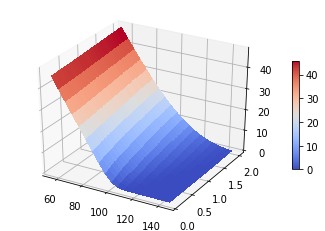

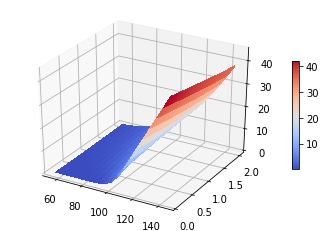

In [4]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# plot target surfaces

fig1 = plt1.figure()
ax1 = fig1.gca(projection='3d')
fig2 = plt2.figure()
ax2 = fig2.gca(projection='3d')

strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

X1 = strikes
X2 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X1, Y1 = np.meshgrid(X1, Y)
X2, Y2 = np.meshgrid(X2, Y)

Call_ITM=ITM_call.detach().numpy()
Call_OTM=OTM_call.detach().numpy()
Put_ITM=ITM_put.detach().numpy()
Put_OTM=OTM_put.detach().numpy()

Z1=np.concatenate([Call_ITM,Call_OTM[0:24,1:10]],1)
Z2=np.concatenate([Put_OTM,Put_ITM[0:24,1:10]],1)

# Plot the surface.
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(X1, Y2, Z2, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig1.colorbar(surf1, shrink=0.5, aspect=15)
fig2.colorbar(surf2, shrink=0.5, aspect=15)
plt1.show()
plt2.show()

(96, 10)


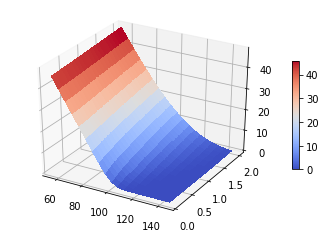

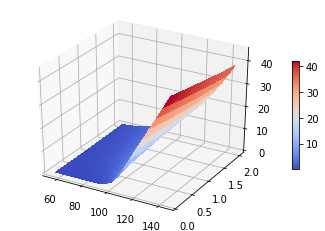

In [6]:
import matplotlib.pyplot as plt3
import matplotlib.pyplot as plt4

# evaluate model on generated 1 million sample paths

batch_size = 1
S0 = torch.ones(batch_size, 1)*100
V0 = torch.ones(batch_size,1)*0.04
rate = torch.ones(batch_size, 1)*0.025
indices = torch.tensor([ 2,4,  6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
 38, 40, 42, 44, 46, 48])    
timegrid = torch.linspace(0,2,49)
N_steps = 22
target_timegrid= torch.linspace(1/12, 2, N_steps + 2)

fig3 = plt3.figure()
ax3 = fig3.gca(projection='3d')
fig4 = plt4.figure()
ax4 = fig4.gca(projection='3d')

strikes_put=[55,60, 65,70,75,80,85,90,95,100]
strikes_call=[100,105,110,115,120,125,130,135, 140,145]
strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

X3 = strikes
X4 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X3, Y3 = np.meshgrid(X3, Y)
X4, Y4 = np.meshgrid(X4, Y)

path = r"Neural_SDE_0_26.pth"
model = Net_SDE(dim=1, timegrid=timegrid, strikes_call=strikes_call,strikes_put=strikes_put,ITM_call=ITM_call,OTM_call=OTM_call,ITM_put=ITM_put,OTM_put=OTM_put, n_layers=2, vNetWidth=20, device=device)
model.load_state_dict(torch.load(path, map_location='cpu'), strict=False)

model=model.to(device=device)
Z=model(S0, V0, rate, indices, z_1,z_2, 2*MC_samples).float().to(device=device)
Z=Z.detach().to(device='cpu').numpy()
print(Z.shape)

Call_NN=np.concatenate([Z[48:72,0:9],Z[0:24,0:10]],1)
Put_NN=np.concatenate([Z[24:48,0:9],Z[72:96,0:10]],1)


# Plot the surface.
surf3 = ax3.plot_surface(X3, Y3, Call_NN, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf4 = ax4.plot_surface(X4, Y4, Put_NN, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig3.colorbar(surf3, shrink=0.5, aspect=15)
fig4.colorbar(surf4, shrink=0.5, aspect=15)
plt3.show()
plt4.show()

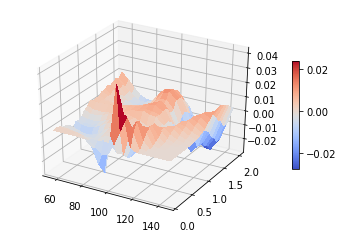

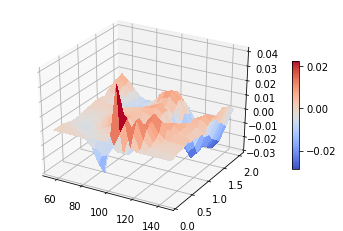

In [7]:
import matplotlib.pyplot as plt5
import matplotlib.pyplot as plt6

# plot difference Model-Target

fig5 = plt5.figure()
ax5 = fig5.gca(projection='3d')
fig6 = plt6.figure()
ax6 = fig6.gca(projection='3d')

strikes_put=[55,60, 65,70,75,80,85,90,95,100]
strikes_call=[100,105,110,115,120,125,130,135, 140,145]
strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

X5 = strikes
X6 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X5, Y5 = np.meshgrid(X5, Y)
X6, Y6 = np.meshgrid(X6, Y)

Call_NN=np.concatenate([Z[48:72,0:9],Z[0:24,0:10]],1)
Put_NN=np.concatenate([Z[24:48,0:9],Z[72:96,0:10]],1)




Z5=Call_NN-np.concatenate([Call_ITM,Call_OTM[0:24,1:10]],1)
Z6=Put_NN-np.concatenate([Put_OTM,Put_ITM[0:24,1:10]],1)

# Plot the surface.
surf5 = ax5.plot_surface(X5, Y5, Z5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf6 = ax6.plot_surface(X6, Y6, Z6, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig5.colorbar(surf5, shrink=0.5, aspect=15)
fig6.colorbar(surf6, shrink=0.5, aspect=15)
plt5.show()
plt6.show()

(96, 10)


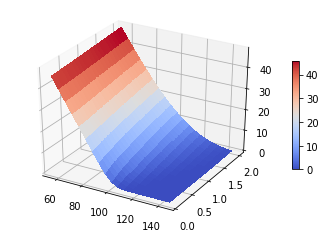

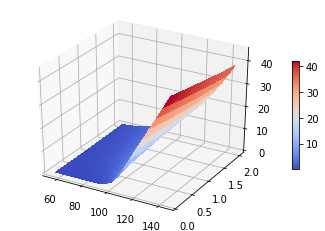

In [8]:
import matplotlib.pyplot as plt7
import matplotlib.pyplot as plt8


# calculate Heston MC prices

batch_size = 1
S0 = torch.ones(batch_size, 1)*100
V0 = torch.ones(batch_size,1)*0.04
rate = torch.ones(batch_size, 1)*0.025
indices = torch.tensor([ 2,4,  6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
 38, 40, 42, 44, 46, 48])    
timegrid = torch.linspace(0,2,49)
N_steps = 22
target_timegrid= torch.linspace(1/12, 2, N_steps + 2)

fig7 = plt7.figure()
ax7 = fig7.gca(projection='3d')
fig8 = plt8.figure()
ax8 = fig8.gca(projection='3d')

strikes_put=[55,60, 65,70,75,80,85,90,95,100]
strikes_call=[100,105,110,115,120,125,130,135, 140,145]
strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

X7 = strikes
X8 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X7, Y7 = np.meshgrid(X7, Y)
X8, Y8 = np.meshgrid(X8, Y)

model = Net_SDE_Heston(dim=1, timegrid=timegrid, strikes_call=strikes_call,strikes_put=strikes_put,ITM_call=ITM_call,OTM_call=OTM_call,ITM_put=ITM_put,OTM_put=OTM_put, n_layers=2, vNetWidth=20, device=device)

model=model.to(device=device)
Z=model(S0, V0, rate, indices, z_1,zz, 2*MC_samples).float().to(device=device)
Z=Z.detach().to(device='cpu').numpy()
print(Z.shape)

Call_Heston=np.concatenate([Z[48:72,0:9],Z[0:24,0:10]],1)
Put_Heston=np.concatenate([Z[24:48,0:9],Z[72:96,0:10]],1)


# Plot the surface.
surf7 = ax7.plot_surface(X7, Y7, Call_NN, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf8 = ax8.plot_surface(X8, Y8, Put_NN, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig7.colorbar(surf7, shrink=0.5, aspect=15)
fig8.colorbar(surf8, shrink=0.5, aspect=15)
plt7.show()
plt8.show()

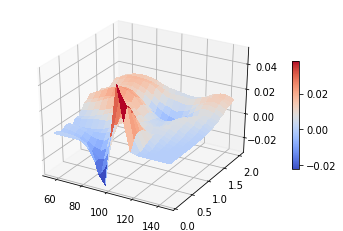

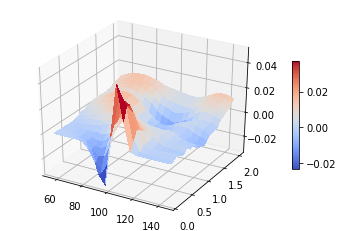

In [9]:
import matplotlib.pyplot as plt9
import matplotlib.pyplot as plt10

# plot difference Heston MC - Target Heston (numerical integration)

fig9 = plt9.figure()
ax9 = fig9.gca(projection='3d')
fig10 = plt10.figure()
ax10 = fig10.gca(projection='3d')

strikes_put=[55,60, 65,70,75,80,85,90,95,100]
strikes_call=[100,105,110,115,120,125,130,135, 140,145]
strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

X9 = strikes
X10 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X9, Y9 = np.meshgrid(X9, Y)
X10, Y10 = np.meshgrid(X10, Y)


Z9=Call_Heston-np.concatenate([Call_ITM,Call_OTM[0:24,1:10]],1)
Z10=Put_Heston-np.concatenate([Put_OTM,Put_ITM[0:24,1:10]],1)

# Plot the surface.
surf9 = ax9.plot_surface(X9, Y9, Z9, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf10 = ax10.plot_surface(X10, Y10, Z10, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig9.colorbar(surf9, shrink=0.5, aspect=15)
fig10.colorbar(surf10, shrink=0.5, aspect=15)
plt9.show()
plt10.show()

In [38]:
losses=np.load('losses0.npy',allow_pickle=True)
losses_val=np.load('losses_val0.npy',allow_pickle=True)

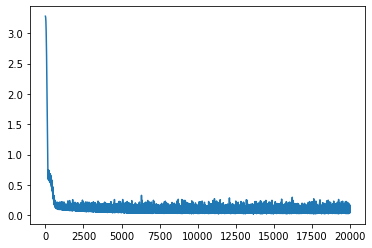

In [39]:
import matplotlib.pyplot as pltloss

# plot objective at each training iteration
# each iteration used only 20k sample paths

x = np.arange(20000)
pltloss.plot(x, losses)
pltloss.show()

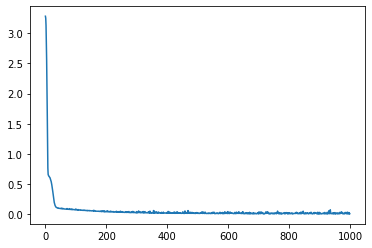

In [40]:
import matplotlib.pyplot as pltval

# every 10 iterations validate model
# by evaluating objective using 200k sample paths

x1 = np.arange(1000)
pltval.plot(x1,losses_val[0:1000])
pltval.show()

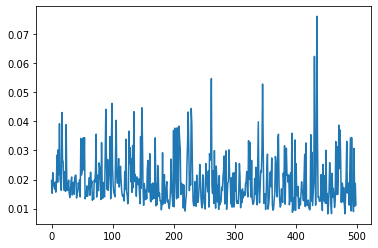

In [41]:
import matplotlib.pyplot as pltval2

# consider final 500 (out of 1000)
# validation objective values

x2 = np.arange(500)
pltval2.plot(x2,losses_val[500:1000])
pltval2.show()

In [42]:
# calculate RMSE over 1 million sample paths for the Model 

mse1 = ((Z5)**2).mean(axis=None)
mse2 = ((Z6)**2).mean(axis=None)
print(np.sqrt((mse1+mse2)/2))

0.007921612227125197


In [43]:
# calculate RMSE over 1 million sample paths for the Heston MC prices 

mse1 = ((Z9)**2).mean(axis=None)
mse2 = ((Z10)**2).mean(axis=None)
print(np.sqrt((mse1+mse2)/2))

0.01026832540290567
